In [16]:
import sys
from string import ascii_uppercase
import itertools
import io
import copy
import time
import matplotlib.ticker as ticker
import random
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [17]:
def isLeft(P0, P1, P2):
    return ((P1[0] - P0[0]) * (P2[1] - P0[1]) - (P2[0] - P0[0]) * (P1[1] - P0[1]))
def wn_PnPoly(P, V):
    n = len(V)-1
    wn= 0    
    i = 0
    while i<n: 
        if V[i][1] <= P[1]:
            
            if V[i+1][1]  > P[1]:   
                if isLeft(V[i], V[i+1], P) > 0: 
                      wn += 1            
        else:                        
              if V[i+1][1] <= P[1]:     
                if isLeft(V[i], V[i+1], P) < 0: 
                      wn -= 1           

        i += 1
  
  #print str(wn)
    return wn;

In [18]:
#test_polygon2 = [ (0,1), (1,1), (1,2), (2,2), (2,3), (3,3), (3,2), (4,0), (5,9), (6,0), 
            #  (7,2), (8,0), (8,-2), (7,-3), (6,-2), (5,-2), (4,-2), (3,-1), (2,-2), (1,-2), 
            #  (0,-3), (-2,-3), (-3,-4), (-4,-3), (-5,-3), (-5,-2), (-4,-2), (-4,.5), (-5,.5), (-5,1), 
              #(-4,1), (-4,2), (-4,4), (-3,4), (-3,2), (-2,2), (-2,0), (-1,1), (0,1) ]
#test_polygon2 = [ (0,0),(-8,4),(-4,12),(13,10),(8,2),(-2,4),(6,6), (2,8), (0,0)]
test_polygon2 = [ (2,4),(10,12),(20,4),(8,2),(10,8),(14,6),(2,4)]

In [19]:
b=list()
k=len(test_polygon2)
for i in range(1,k):
    m=(test_polygon2[i%k][1]-test_polygon2[(i-1)%k][1])/(test_polygon2[i%k][0]-test_polygon2[(i-1)%k][0])
    n=(test_polygon2[i%k][1]-m*test_polygon2[i%k][0])
    b.append((m,n))

In [20]:
rectas=pd.DataFrame(b)
rectas.columns=['pendiente','intersepto']
rectas['punto_1']=test_polygon2[0:len(test_polygon2)-1]
rectas['punto_2']=test_polygon2[1:len(test_polygon2)]
rectas

,pendiente,intersepto,punto_1,punto_2
0,1.000000,2.000000,"(2, 4)","(10, 12)"
1,-0.800000,20.000000,"(10, 12)","(20, 4)"
2,0.166667,0.666667,"(20, 4)","(8, 2)"
3,3.000000,-22.000000,"(8, 2)","(10, 8)"
4,-0.500000,13.000000,"(10, 8)","(14, 6)"
5,0.166667,3.666667,"(14, 6)","(2, 4)"


In [21]:
from itertools import combinations
intersecciones=list()
combine=combinations(list(range(0,len(rectas))),r= 2)
for i in combine:
    interx=(rectas.intersepto[i[1]]-rectas.intersepto[i[0]])/(rectas.pendiente[i[0]]-rectas.pendiente[i[1]])
    intery=rectas.pendiente[i[1]]*interx+rectas.intersepto[i[1]]
    if (rectas.punto_1[i[0]][0]<interx<rectas.punto_2[i[0]][0] or rectas.punto_2[i[0]][0]<interx<rectas.punto_1[i[0]][0]) and  (rectas.punto_1[i[1]][0]<interx<rectas.punto_2[i[1]][0] or rectas.punto_2[i[1]][0]<interx<rectas.punto_1[i[1]][0]) and (rectas.punto_1[i[0]][1]<intery<rectas.punto_2[i[0]][1] or rectas.punto_2[i[0]][1]<intery<rectas.punto_1[i[0]][1] ) and ( rectas.punto_1[i[1]][1]<intery<rectas.punto_2[i[1]][1] or rectas.punto_2[i[1]][1]<intery<rectas.punto_1[i[1]][1] )  :
        intersecciones.append((interx.round(3),intery.round(3)))
intersecciones    

[(9.059, 5.176)]

In [22]:
L_X=list()
L_Y=list()
for i in range(len(test_polygon2)-1):
    L_X.append(rectas['punto_1'][i][0])
    L_Y.append(rectas['punto_1'][i][1])
x_limsup=max(L_X)   
x_liminf=min(L_X)
y_limsup=max(L_Y)
y_liminf=min(L_Y)

In [23]:

test_polygon4=list()
random.seed(1389)
i = 0
t = time.perf_counter()
while i < 900000:
    testpoint = (0.01*random.randrange(x_liminf*100, x_limsup*100), 0.01*random.randrange(y_liminf*100, y_limsup*100))
    wn=wn_PnPoly(testpoint, test_polygon2)
    if wn != 0 :
        test_polygon4.append(testpoint)
    i += 1  

Text(0, 0.5, 'y')

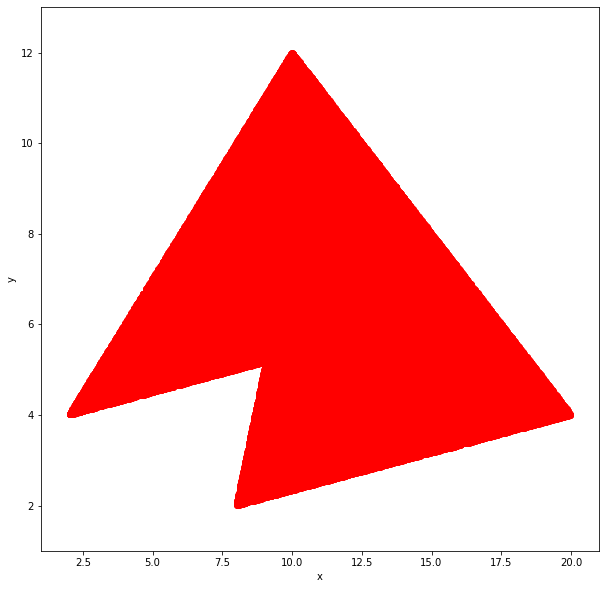

In [25]:
test_polygon5=pd.DataFrame(test_polygon4)
x=test_polygon5.iloc[:,0]
y=test_polygon5.iloc[:,1]
#print(data)
fig = plt.figure(figsize=(10, 10)) 
plt.plot(x,y,"ro")
plt.ylim(y_liminf-1,y_limsup+1)
plt.xlim(x_liminf-1,x_limsup+1)
plt.xlabel("x")
plt.ylabel("y")